In [1]:
%matplotlib inline

In [53]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
matplotlib.style.use('ggplot')
# matplotlib.style.use('default')

In [12]:
import quantum_simulation_bb84 as bb84
reload(bb84)

import quantum_simulation_e91 as e91
reload(e91)

<module 'quantum_simulation_e91' from 'quantum_simulation_e91.py'>

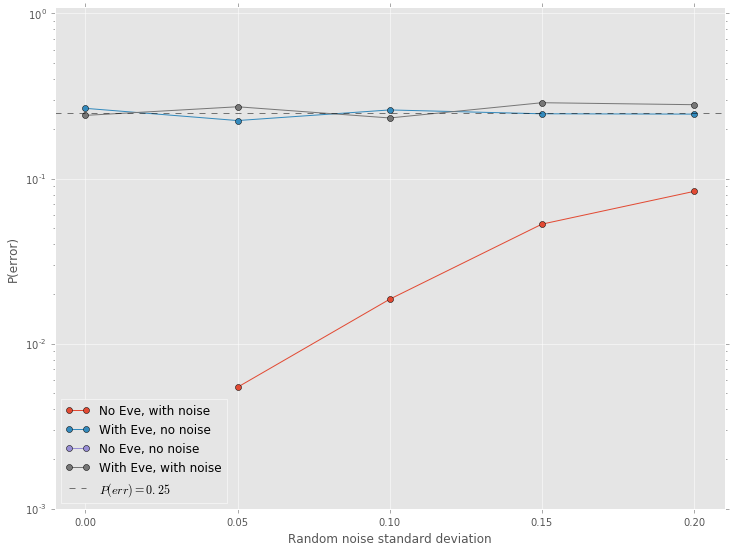

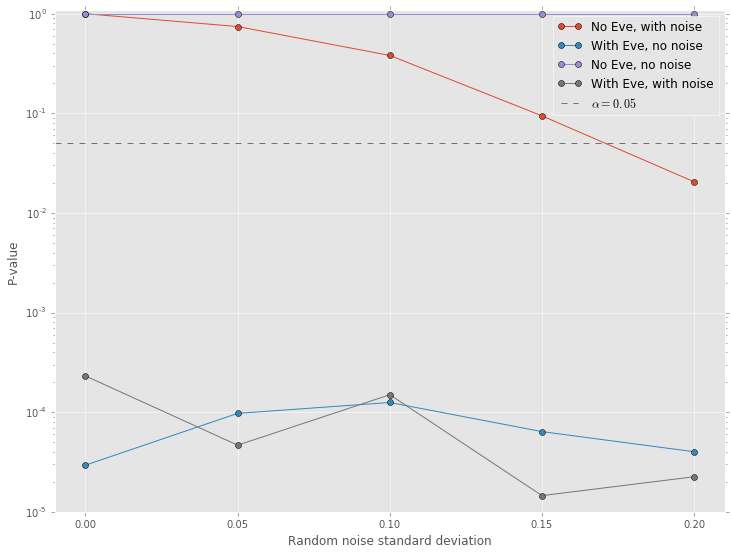

In [4]:
ERROR_SIGMA_VALUES = (0.00, 0.05, 0.10, 0.15, 0.20)
SAMPLE_SIZE = 256
TRIALS = 20

NO_EVE_NO_NOISE = (False, False)
YES_EVE_NO_NOISE = (True, False)
NO_EVE_YES_NOISE = (False, True)
YES_EVE_YES_NOISE = (True, True)

CONFIGURATIONS = (NO_EVE_NO_NOISE, YES_EVE_NO_NOISE, NO_EVE_YES_NOISE, YES_EVE_YES_NOISE)

P_ERROR = 'P(error)'
P_VALUE = 'P-value'

results = defaultdict(lambda: defaultdict(dict))
for sigma in ERROR_SIGMA_VALUES:
    configurations = {key: (SAMPLE_SIZE, key[0], 
                            bb84.generate_gaussian_noise(sigma=sigma) if key[1] else bb84.ZERO_NOISE_LAMBDA)
                     for key in CONFIGURATIONS}

    for key in configurations:
        current = [bb84.simulate_bb84(*configurations[key]) for _ in range(TRIALS)]
        avg_p_err, avg_t, avg_p_value = np.average(current, 0)
        results[key][sigma][P_ERROR] = avg_p_err
        results[key][sigma][P_VALUE] = avg_p_value
        

KEY_PARAMETERS = {NO_EVE_NO_NOISE: {'label': 'No Eve, no noise'},
                  YES_EVE_NO_NOISE: {'label': 'With Eve, no noise'},
                  NO_EVE_YES_NOISE: {'label': 'No Eve, with noise'},
                  YES_EVE_YES_NOISE: {'label': 'With Eve, with noise'}
                 }

for metric in (P_ERROR, P_VALUE):
    plt.figure(figsize=(12, 9), dpi=1000)
    plt.xlabel('Random noise standard deviation')
    plt.ylabel(metric)
    
    for key in KEY_PARAMETERS:
        plt.semilogy(ERROR_SIGMA_VALUES, 
                     [results[key][sigma][metric] for sigma in ERROR_SIGMA_VALUES],
                     label=KEY_PARAMETERS[key]['label'], marker='o')
    
    if metric == P_VALUE:
        plt.axhline(y=0.05, label=r'$\alpha = 0.05$', color='black', alpha=0.5, ls='--')
        
    else:  # metric == P_ERROR
        plt.axhline(y=0.25, label=r'$P(err) = 0.25$', color='black', alpha=0.5, ls='--')

    y_min, y_max = plt.ylim()
    plt.xlim(-0.01, 0.21)
    plt.ylim(y_min, y_max + 0.1)
    plt.legend(loc='best')
    plt.show()
        
        

(array([  5.,   3.,  13.,  18.,  13.,  15.,  17.,   8.,   5.,   3.]),
 array([-2.98016632, -2.95023269, -2.92029905, -2.89036542, -2.86043178,
        -2.83049815, -2.80056452, -2.77063088, -2.74069725, -2.71076362,
        -2.68082998]),
 <a list of 10 Patch objects>)

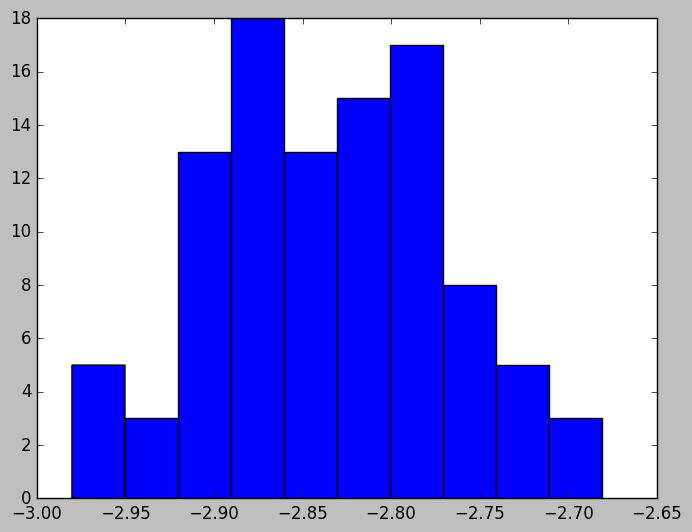

In [13]:
results = [e91.simulate_e91() for _ in range(10 ** 2)]
plt.hist(results)

In [71]:
ERROR_SIGMA_VALUES = (0.00, 0.05, 0.10, 0.15, 0.20)
SAMPLE_SIZE = 256
TRIALS = 50

NO_EVE_NO_NOISE = (False, False, False)
ALICE_EVE_NO_NOISE = (True, False, False)
BOB_EVE_NO_NOISE = (False, True, False)
NO_EVE_YES_NOISE = (False, False, True)
ALICE_EVE_YES_NOISE = (True, False, True)
BOB_EVE_YES_NOISE = (False, True, True)

CONFIGURATIONS = (NO_EVE_NO_NOISE, ALICE_EVE_NO_NOISE, BOB_EVE_NO_NOISE,
                  NO_EVE_YES_NOISE, ALICE_EVE_YES_NOISE, BOB_EVE_YES_NOISE)

EVE_BASIS = e91.QuantumBasis(e91.COMPUTATIONAL_VECS, '0')

results = defaultdict(dict)
for sigma in ERROR_SIGMA_VALUES:
    configurations = {key: (SAMPLE_SIZE, key[0], key[1], EVE_BASIS,
                            bb84.generate_gaussian_noise(sigma=sigma) if key[2] else bb84.ZERO_NOISE_LAMBDA)
                     for key in CONFIGURATIONS}

    for key in configurations:
        results[key][sigma] = [e91.simulate_e91(*configurations[key]) for _ in range(TRIALS)]
        

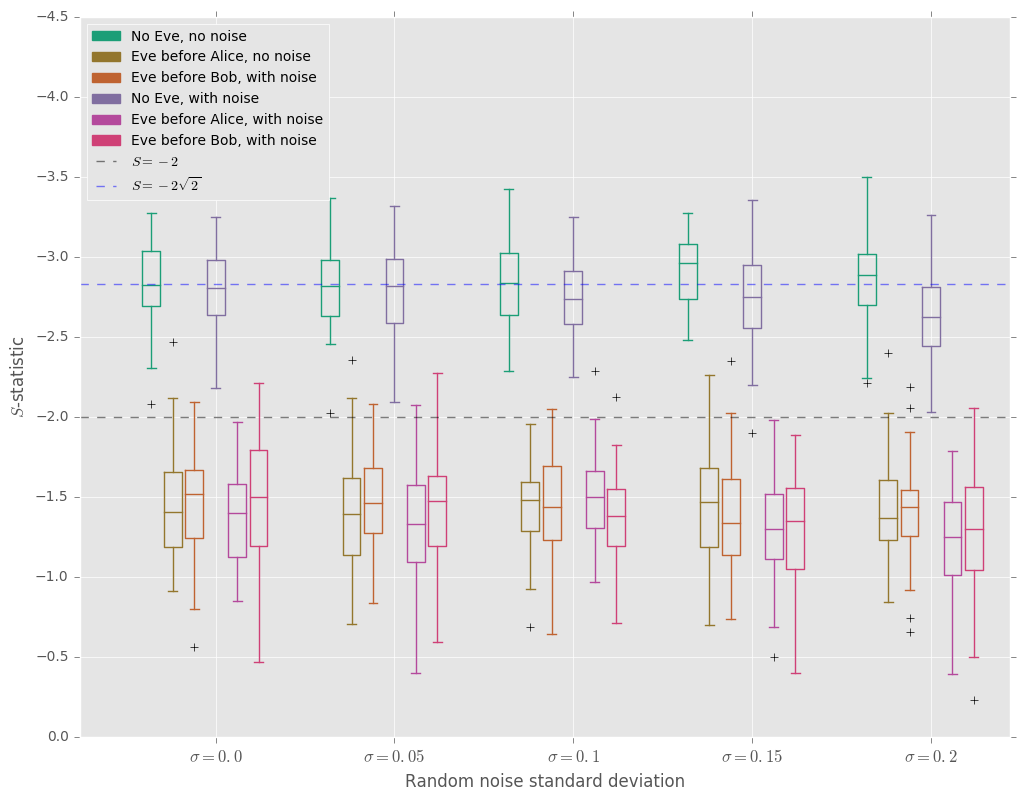

In [74]:
KEY_PARAMETERS = {NO_EVE_NO_NOISE: {'label': 'No Eve, no noise'},
                  ALICE_EVE_NO_NOISE: {'label': 'Eve before Alice, no noise'},
                  BOB_EVE_NO_NOISE: {'label': 'Eve before Bob, with noise'},
                  NO_EVE_YES_NOISE: {'label': 'No Eve, with noise'},
                  ALICE_EVE_YES_NOISE: {'label': 'Eve before Alice, with noise'},
                  BOB_EVE_YES_NOISE: {'label': 'Eve before Bob, with noise'}
                 }


plt.figure(figsize=(12, 9), dpi=1000)
plt.xlabel('Random noise standard deviation')
plt.ylabel(r'$S$-statistic')

STEP = 0.6

positions = np.arange(0, 
                      STEP * (len(CONFIGURATIONS) + 1) * len(ERROR_SIGMA_VALUES), 
                       len(ERROR_SIGMA_VALUES))

legend_handles = []

for key, index in zip(CONFIGURATIONS, range(len(KEY_PARAMETERS))):
    props = dict(color=E91_COLOR_MAP[index])
    plt.boxplot([results[key][sigma] for sigma in ERROR_SIGMA_VALUES],
                positions=positions + (STEP * index),
                capprops=props, boxprops=props, whiskerprops=props,
                meanprops=props, medianprops=props ) #flierprops=props,
                #labels=[KEY_PARAMETERS[key]['label']] * len(ERROR_SIGMA_VALUES))

    legend_handles.append(mpatches.Patch(label=KEY_PARAMETERS[key]['label'], **props))

plt.axhline(y=-2, label=r'$S = -2$', color='black', alpha=0.5, ls='--')
plt.axhline(y=-2 * (2 ** 0.5), label=r'$S = -2\sqrt{2}$', color='blue', alpha=0.5, ls='--')
        
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=legend_handles + handles, loc='best', fontsize=10)

x_tick_locs = positions + (STEP * 3)
x_tick_values = [r'$\sigma = {sigma}$'.format(sigma=sigma) for sigma in ERROR_SIGMA_VALUES]
plt.xticks(x_tick_locs, x_tick_values, fontsize=12)

plt.xlim(-2, 24)
plt.ylim(0, -4.5)
plt.show()

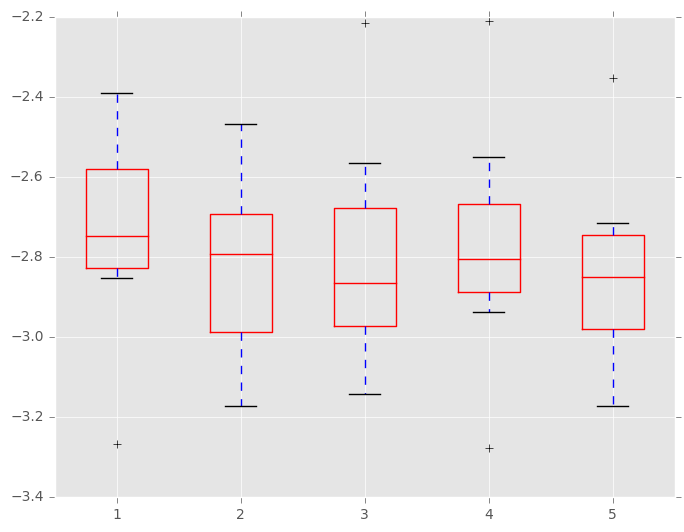

In [61]:
box = plt.boxplot([results[(False, False, False)][sigma] for sigma in ERROR_SIGMA_VALUES],
           boxprops=dict(color='red'))

In [ ]:
a = bb84.BB84Agent()
b = bb84.BB84Agent()

qubits = a.send_qubits(10)
#print qubits
#print [a.used_bases[i].interpret(int(a.bits[i])) for i in range(10)]
b.measure(qubits)

b.used_bases[0].basis_vectors[0][]

[[ 0.10588235  0.61960787  0.46666667  1.        ]
 [ 0.57631681  0.4636217   0.17697809  1.        ]
 [ 0.74794311  0.39006537  0.19021915  1.        ]
 [ 0.50034602  0.43215687  0.62846599  1.        ]
 [ 0.70602077  0.28525952  0.61305654  1.        ]
 [ 0.8126413   0.25113419  0.46311421  1.        ]
 [ 0.49324107  0.56063054  0.19570935  1.        ]
 [ 0.624406    0.65974627  0.06855825  1.        ]
 [ 0.8753864   0.64858133  0.01905421  1.        ]
 [ 0.71692428  0.51735487  0.08590542  1.        ]
 [ 0.55846215  0.43961554  0.21925414  1.        ]
 [ 0.40000001  0.40000001  0.40000001  1.        ]]


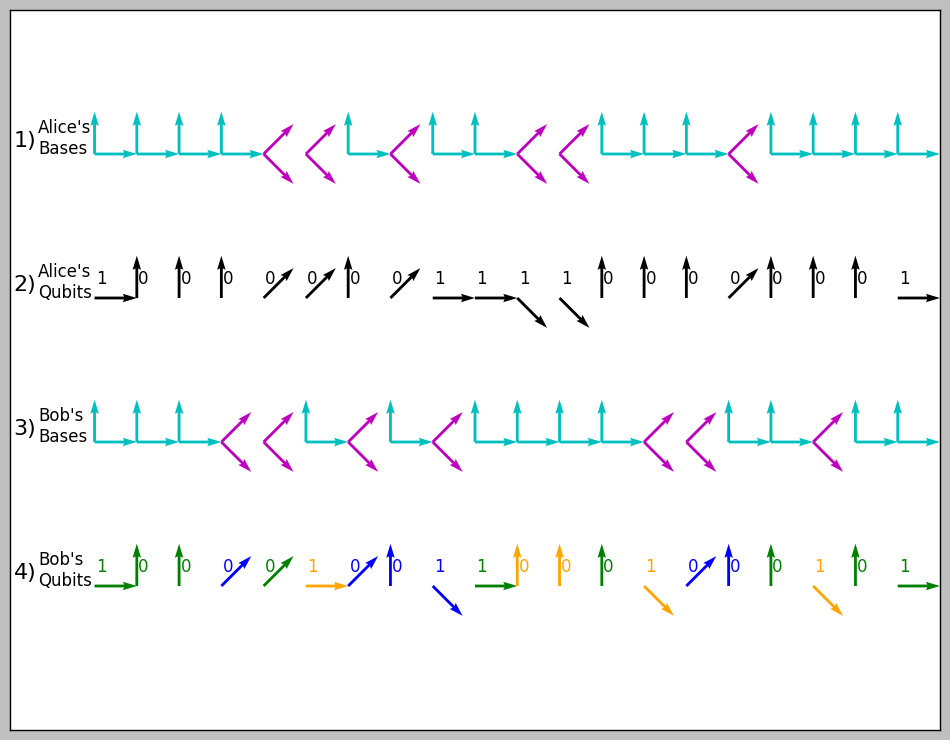

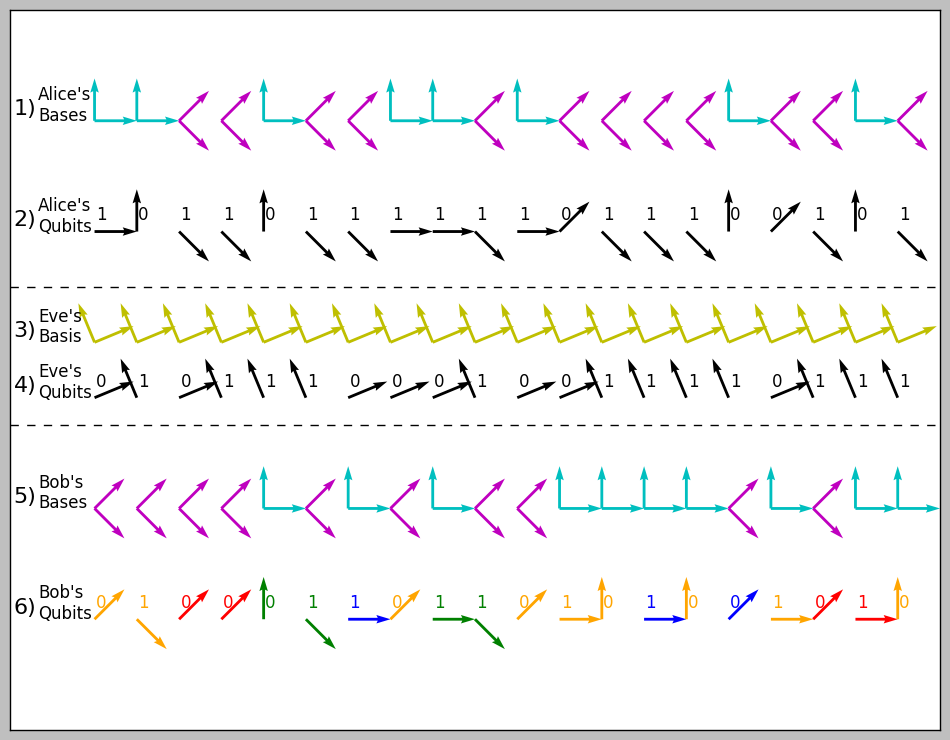

In [6]:
X_PADDING = 30
Y_PADDING = 10
X_STEP = 30
Y_STEP = 10
TEXT_X = -10
NUMBER_X = -27.5
SCALE = 22.0
MINSHAFT = 3


BASIS_COLOR_MAP = {bb84.COMPUTATIONAL_NAME: 'c',
                  bb84.HADAMARD_NAME: 'm',
                  bb84.EVE_NAME: 'y'}

E_91_NAMES = ('0', 'PI / 8', 'PI / 4', '-PI / 8')
E91_COLOR_MAP = plt.get_cmap('Dark2')(np.linspace(0, 1, 12))
BASIS_COLOR_MAP.update({k: v for k, v in zip(E_91_NAMES, E91_COLOR_MAP)})

BB84_QUBIT_COLOR_MAP = {(True, True): 'g', (False, True): 'b', (False, False): 'orange', (True, False): 'red'}
DEFAULT_QUBIT_COLOR = 'black'

def plot_bases_arrows(used_bases, x, height):
    bases_x = x
    bases_y = [Y_STEP * height] * len(bases_x)
    
    if isinstance(used_bases[0].basis_vectors[0], np.matrix):
        bases_u = [(basis.basis_vectors[0][0, 0], basis.basis_vectors[1][0, 0]) for basis in used_bases]
        bases_u = [item for sublist in bases_u for item in sublist]

        bases_v = [(basis.basis_vectors[0][0, 1], basis.basis_vectors[1][0, 1]) for basis in used_bases]
        bases_v = [item for sublist in bases_v for item in sublist]
        
        # Yes, this is ugly:
        colors = [BASIS_COLOR_MAP[basis.name] for basis in used_bases]
        bases_c = []
        for color in colors:
            bases_c.append(color)
            bases_c.append(color)
        
    else:
        bases_u = [(basis.basis_vectors[0][0], basis.basis_vectors[1][0]) for basis in used_bases]
        bases_u = [item for sublist in bases_u for item in sublist]

        bases_v = [(basis.basis_vectors[0][1], basis.basis_vectors[1][1]) for basis in used_bases]
        bases_v = [item for sublist in bases_v for item in sublist]
        
        bases_c = np.repeat([BASIS_COLOR_MAP[basis.name] for basis in used_bases], 2)

    plt.quiver(bases_x, bases_y, bases_u, bases_v, color=bases_c, scale=SCALE, minshaft=MINSHAFT)


def plot_qubit_arrows(qubits, x, height, bits=None, reference_bits=None,
                      bases=None, reference_bases=None,
                      color=DEFAULT_QUBIT_COLOR, color_map=BB84_QUBIT_COLOR_MAP):
    qubits_x = x
    qubits_y = [Y_STEP * height] * len(qubits_x)
    qubits_u, qubits_v = zip(*qubits)
    
    if reference_bits is not None and bases is not None and reference_bases is not None:
        truth_values = zip(np.array(bases) == np.array(reference_bases), bits == reference_bits)
        color = [color_map[result] for result in truth_values]
        
    else:
        color = [color] * len(qubits)
    
    plt.quiver(qubits_x, qubits_y, qubits_u, qubits_v, color=color, scale=SCALE, minshaft=MINSHAFT)
    
    if bits is not None:
        for bit, x, y, c in zip(bits, qubits_x, qubits_y, color):
            xy = x + 1, y + 1
            plt.annotate(str(int(bit)), xy, color=c)


def plot_bb84(n=10, eve=False, noise=bb84.ZERO_NOISE_LAMBDA):
    alice = bb84.BB84Agent(noise=noise)
    bob = bb84.BB84Agent(noise=noise)
    fig = plt.figure(figsize=(12, 9), dpi=1000)
    
    height = 0
    step = 1
    
    x = [i * X_STEP for i in range(1, n + 1)]
    repeated_x = np.repeat(x, 2)
    
    alice_qubits = alice.send_qubits(n)
    
    plot_bases_arrows(alice.used_bases, repeated_x, height)
    plt.annotate(s="Alice's\nBases", xy=(TEXT_X, Y_STEP * height))
    plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height + 0.5), fontsize=16)
    
    height -= 1
    step += 1
    
    plot_qubit_arrows(alice_qubits, x, height, alice.bits)
    plt.annotate(s="Alice's\nQubits", xy=(TEXT_X, Y_STEP * height))
    plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height + 0.5), fontsize=16)
    
    if eve:
        height -= 0.5
        plt.axhline(Y_STEP * height, color='black', ls='--')
        
        eve = bb84.BB84Agent((bb84.EVE_NAME,), noise=noise)
        eve.measure(alice_qubits)
        
        height -= 0.5
        step += 1
        plot_bases_arrows(eve.used_bases, repeated_x, height)
        plt.annotate(s="Eve's\nBasis", xy=(TEXT_X, Y_STEP * height))
        plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height + 0.5), fontsize=16)
        
        height -= 0.5
        step += 1 
        
        original_alice_qubits = alice_qubits
        eve_qubits = [eve.bases[0].generate(bit) for bit in eve.bits]
        plot_qubit_arrows(eve_qubits, x, height, eve.bits) 
        plt.annotate(s="Eve's\nQubits", xy=(TEXT_X, Y_STEP * height))
        plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height + 0.5), fontsize=16)
        
        alice_qubits = eve_qubits
        
        height -= 0.25
        plt.axhline(Y_STEP * height, color='black', ls='--')
        
        height -= 0.75
    
    else:
        height -= 1
        
    step += 1
    bob.measure(alice_qubits)

    plot_bases_arrows(bob.used_bases, repeated_x, height)
    plt.annotate(s="Bob's\nBases", xy=(TEXT_X, Y_STEP * height))
    plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height + 0.5), fontsize=16)
    
    height -= 1
    step += 1
    
    bob_qubits = [bob.used_bases[i].interpret(int(bob.bits[i])) for i in range(n)]
    # TODO: consider how to handle this with Eve
    plot_qubit_arrows(bob_qubits, x, height, bob.bits, alice.bits,
                      bob.used_bases, alice.used_bases) 
    plt.annotate(s="Bob's\nQubits", xy=(TEXT_X, Y_STEP * height))
    plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height + 0.5), fontsize=16)
    
    x_min, x_max = plt.xlim()
    plt.xlim(x_min - X_PADDING, x_max + X_PADDING)
    y_min, y_max = plt.ylim()
    plt.ylim(y_min - Y_PADDING, y_max + Y_PADDING)
    
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_bgcolor("whitesmoke")
    plt.show()
    
plot_bb84(20)
plot_bb84(20, True)
# plot_bb84(20, noise=bb84.generate_gaussian_noise(sigma=0.05))

In [ ]:
alice, bob = e91.generate_alice_bob()
qubits = [e91.QubitPair() for _ in range(10)]
alice.measure_qubits(qubits)
bob.measure_qubits(qubits)

In [ ]:
TANGLED_COLOR = 'orange'
EVE_COLOR = 'red'

E91_QUBIT_COLOR_MAP = {(True, True): 'red', (False, True): 'purple', 
                       (False, False): 'blue', (True, False): 'green'}

def get_qubits_from_bits(agent, flip=False):
    return [np.squeeze(np.asarray(base.interpret(flip ^ bit))) 
            for base, bit in zip(agent.used_bases, agent.bits)]


def plot_e91(n=15, eve_before_alice=False, 
             eve_before_bob=False,
             noise=e91.ZERO_NOISE_LAMBDA):
    alice, bob = e91.generate_alice_bob(noise)
    plt.figure(figsize=(12, 9), dpi=1000)
    
    height = 0
    step = 0
    
    x = [i * X_STEP for i in range(1, n + 1)]
    repeated_x = np.repeat(x, 2)
    
    plt.axhline(linewidth=2, ls='--', color='red', alpha=0.5)
    plt.scatter(x, [0] * len(x), marker='*', s=500, color='orange')
    plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height - 1), fontsize=16)
    
    qubits = [e91.QubitPair(noise=noise) for _ in range(n)]
    
    height += 1
    step += 1
    
    plot_qubit_arrows([np.squeeze(np.asarray(pair.first)) for pair in qubits], 
                      x, height, color=TANGLED_COLOR)
    plot_qubit_arrows([np.squeeze(np.asarray(pair.second)) for pair in qubits], 
                      x, -1 * height, color=TANGLED_COLOR)
    
    plt.annotate(s="Alice's\nQubits", xy=(TEXT_X, Y_STEP * height))
    plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height + 0.5), fontsize=16)
    
    # TODO: introduce eve flag here
    
    # TODO: demonstrate that both are measuring the result of collapse on eve's measurements
    
    # First plot the uncollapsed qubits, measure to collapse, plot the collapsed    
    if eve_before_alice:
        eve_basis = e91.QuantumBasis(e91.COMPUTATIONAL_VECS, '0', noise=noise)
        [qubit.measure(eve_basis) for qubit in qubits]
        
        plot_qubit_arrows([np.squeeze(np.asarray(pair.first)) for pair in qubits], 
                      x, height, color=EVE_COLOR)
        plot_qubit_arrows([np.squeeze(np.asarray(pair.second)) for pair in qubits], 
                      x, -1 * height, color=EVE_COLOR)
        
        plt.axhline(y=Y_STEP * height - 4.25, linewidth=2, ls='--', color=EVE_COLOR, alpha=0.5)
        plt.annotate(s="Eve measures and collapses qubits", 
                     xy=(TEXT_X, Y_STEP * height - 3.5), color=EVE_COLOR)
        
        alice.measure_qubits(qubits)
        bob.measure_qubits(qubits)
        
    elif eve_before_bob:
        alice.measure_qubits(qubits)
        eve_basis = e91.QuantumBasis(e91.COMPUTATIONAL_VECS, '0', noise=noise)
        [qubit.measure(eve_basis, second=True) for qubit in qubits]
        
        plot_qubit_arrows([np.squeeze(np.asarray(pair.second)) for pair in qubits], 
                      x, -1 * height, color=EVE_COLOR)
        
        plt.axhline(y=Y_STEP * height * -1 + 6, linewidth=2, ls='--', color=EVE_COLOR, alpha=0.5)
        plt.annotate(s="Eve measures and collapses qubits", 
                     xy=(TEXT_X, Y_STEP * height * -1 + 6.5), color=EVE_COLOR)
        
        bob.measure_qubits(qubits)
        
    else:
        alice.measure_qubits(qubits)
        bob.measure_qubits(qubits)
        
        bob_collapsed_values = get_qubits_from_bits(alice, flip=True)
        plot_qubit_arrows(bob_collapsed_values, x, -1 * height)
    
    plt.annotate(s="Bob's\nQubits", xy=(TEXT_X, Y_STEP * height * -1))
    plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height * -1 + 1.5), fontsize=12)
    plt.annotate(s="{step})".format(step=step + 2), xy=(NUMBER_X, Y_STEP * height * -1 - 0.5), fontsize=12)
    
    height +=1 
    step += 1
    
    plot_bases_arrows(alice.used_bases, repeated_x, height)
    plt.annotate(s="Alice's\nBases", xy=(TEXT_X, Y_STEP * height))
    plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height + 0.5), fontsize=16)
    
    plot_bases_arrows(bob.used_bases, repeated_x, -1 * height)
    plt.annotate(s="Bob's\nBases", xy=(TEXT_X, Y_STEP * height * -1))
    plt.annotate(s="{step})".format(step=step + 2), xy=(NUMBER_X, Y_STEP * height * -1 + 0.5), fontsize=16)

    height +=1 
    step += 1
    
    alice_qubits = get_qubits_from_bits(alice)
    bob_qubits = get_qubits_from_bits(bob)

    plot_qubit_arrows(alice_qubits, x, height, bits=np.array(alice.bits, dtype=np.dtype('bool')))
        #, eve and original_alice_qubits or alice_qubits) 
    plt.annotate(s="Alice's\nMeasured\nValues", xy=(TEXT_X, Y_STEP * height))
    plt.annotate(s="{step})".format(step=step), xy=(NUMBER_X, Y_STEP * height + 1), fontsize=16)

    plot_qubit_arrows(bob_qubits, x, height * -1, bits=np.array(bob.bits, dtype=np.dtype('bool')), 
                      reference_bits=np.array(alice.bits, dtype=np.dtype('bool')), 
                      bases=bob.used_bases, reference_bases=alice.used_bases,
                      color_map=E91_QUBIT_COLOR_MAP) 
                      #reference_qubits=bob_collapsed_values, color_map=E91_QUBIT_COLOR_MAP) 
                        #, eve and original_alice_qubits or alice_qubits) 
    plt.annotate(s="Bob's\nMeasured\nValues", xy=(TEXT_X, Y_STEP * height * -1))
    plt.annotate(s="{step})".format(step=step + 2), xy=(NUMBER_X, Y_STEP * height * -1 + 1), fontsize=16)

    x_min, x_max = plt.xlim()
    plt.xlim(x_min - X_PADDING, x_max + X_PADDING / 2)
    y_min, y_max = plt.ylim()
    plt.ylim(y_min, y_max)
    
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_bgcolor("whitesmoke")
    plt.show()
    
plot_e91(10)
plot_e91(10, eve_before_alice=True)
plot_e91(10, eve_before_bob=True)


In [ ]:
E91_COLOR_MAP

In [ ]:
a = np.array((0, 1))
a + np.random.normal(scale=0.05, size=(1,2))

In [ ]:
from functools import partial
p = partial(np.random.normal, 0, 0.05, (1,2))

In [ ]:
p = lambda: 0
for _ in range(10):
    v = a + p()
    print v / np.linalg.norm(v), np.linalg.norm(v / np.linalg.norm(v))

In [ ]:
np.array(alice.used_bases) == np.array(bob.used_bases)

In [ ]:
[a == b for a, b in zip(alice.used_bases, bob.used_bases)]